# Modelo de clasificación multiclase

## Importaciones de paquetes necesarios

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(len(tf.config.list_physical_devices('GPU'))>0)

2.9.0
True


## Carga de datos

Descargamos el conjunto de imágenes que usaremos para entrenar el modelo.

In [ ]:
# if "food-101" in os.listdir():
#   print("Ya tienes las imágenes de food101")
# else:
#   print("Se van a descargar las imágenes...")
#   !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
#   food_tar = tarfile.open('food-101.tar.gz')
#   food_tar.extractall('.')
#   food_tar.close()

Guardamos la ruta donde estarán las imágenes en una variable.

In [ ]:
base_dir = 'food-101/images'

Guardamos en una lista todos los nombres de las clases de platos de comida que hay.

In [ ]:
class_names = sorted(os.listdir(base_dir))
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [ ]:
# class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}
# class_to_index

## Visualización de las imágenes

A continuación vamos a visualizar una imagen aleatoria para cada clase.

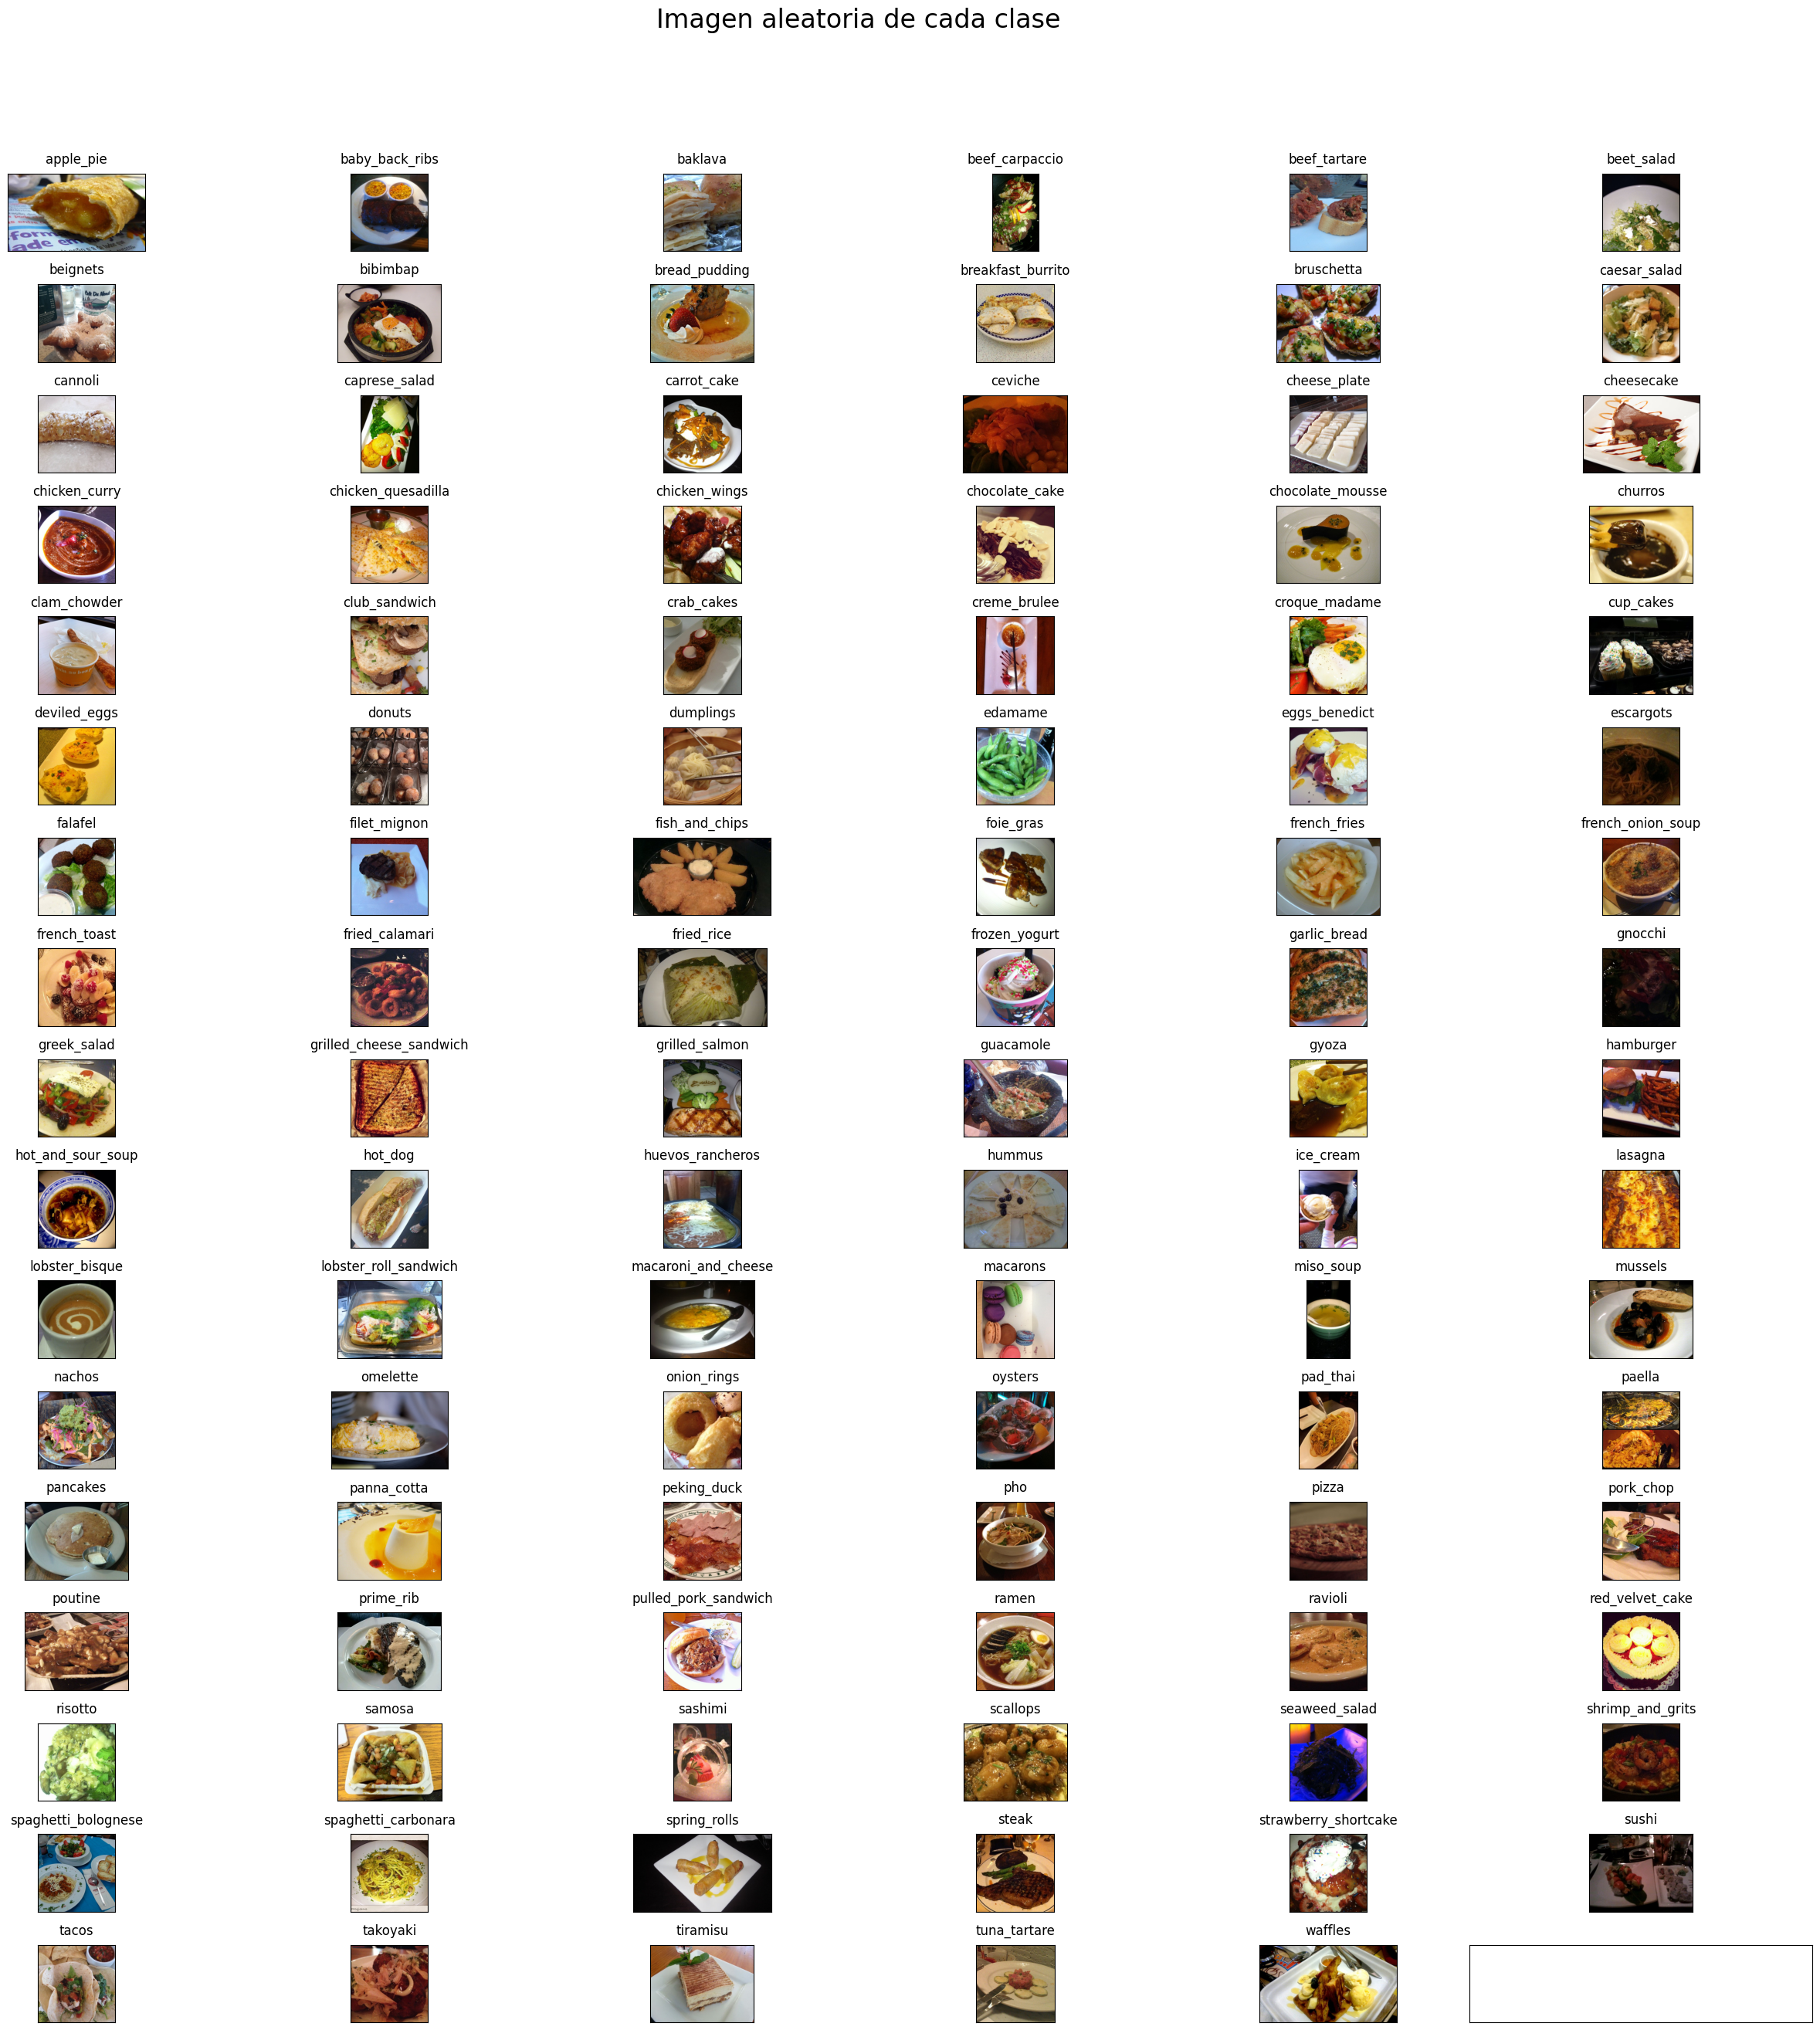

In [ ]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Imagen aleatoria de cada clase", y=1.05, fontsize=24)
foods_sorted = sorted(os.listdir(base_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(base_dir,food_selected))
    food_selected_random = np.random.choice(food_selected_images)
    img = plt.imread(os.path.join(base_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()


## Entrenamiento del modelo

Asignamos las variables necesarias.

In [ ]:
img_width, img_height = 150, 150
nb_train_samples = 80800
nb_validation_samples = 20200
batch_size = 8
epoch = 100

Realizamos la generalización de datos de entrenamiento y de validación.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset = "training")

validation_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset = "validation")

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [ ]:
# train_generator.class_indices = class_to_index
# validation_generator.class_indices = class_to_index

### Modelo con InceptionV3

Creamos el modelo integrando InceptionV3, una capa de agrupación global para convertir la salida 3D en un vector 1D, también capas densas con activación ReLU y dropout, y por último la capa de salida con la función de activación softmax ya que es un problema de clasificación múltiple.

In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False)

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(len(class_names),kernel_regularizer=l1(0.005), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=predictions)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_940 (Conv2D)            (None, None, None,   864         ['input_11[0][0]']               
                                32)                                                               
                                                                                                  
 batch_normalization_940 (Batch  (None, None, None,   96         ['conv2d_940[0][0]']             
 Normalization)                 32)                                                        

Compila el modelo utilizando el optimizador SGD con una tasa de aprendizaje baja, función de pérdida categórica y métrica de precisión.

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Establecemos un callback para que se vaya guardando el modelo en cada iteracción, siempre que las métricas sean mejor que la anterior.

In [ ]:
cb_early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath='Modelos entrenados/best_model_trained.h5', verbose=1, save_best_only=True)

Utiliza el conjunto de datos de entrenamiento y validación para entrenar el modelo.

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator),
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator),
                    epochs = epoch,
                    verbose = 1,
                    callbacks = [cb_early_stopper, checkpointer])

model.save('Modelos entrenados/model_trained.hdf5')
model.save('Modelos entrenados/model_trained.h5')

Epoch 1/100
10100/10100 [==============================] - ETA: 0s - loss: 8.0541 - accuracy: 0.0767
Epoch 00001: val_loss improved from inf to 6.02183, saving model to Modelos entrenados\best_model_trained.h5
10100/10100 [==============================] - 896s 88ms/step - loss: 8.0541 - accuracy: 0.0767 - val_loss: 6.0218 - val_accuracy: 0.2165
Epoch 2/100
10100/10100 [==============================] - ETA: 0s - loss: 5.2998 - accuracy: 0.1895
Epoch 00002: val_loss improved from 6.02183 to 4.00133, saving model to Modelos entrenados\best_model_trained.h5
10100/10100 [==============================] - 884s 88ms/step - loss: 5.2998 - accuracy: 0.1895 - val_loss: 4.0013 - val_accuracy: 0.3080
Epoch 3/100
10100/10100 [==============================] - ETA: 0s - loss: 4.1038 - accuracy: 0.2308
Epoch 00003: val_loss improved from 4.00133 to 3.34407, saving model to Modelos entrenados\best_model_trained.h5
10100/10100 [==============================] - 881s 87ms/step - loss: 4.1038 - accurac

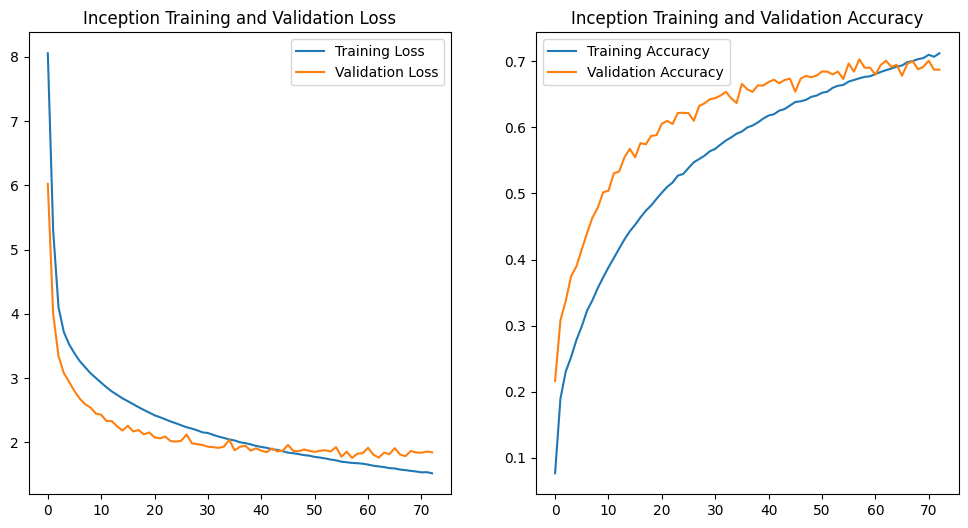

In [ ]:
plot = pd.DataFrame(history.history)

# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plot['loss'], label='Training Loss')
plt.plot(plot['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Inception Training and Validation Loss')

# Gráfica de accuracy
plt.subplot(1, 2, 2)
plt.plot(plot['accuracy'], label='Training Accuracy')
plt.plot(plot['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Inception Training and Validation Accuracy')

# Mostrar las gráficas
plt.show()